# 0.0 IMPORTS

In [1]:
# Bibliotecas

import math
import numpy as np
import pickle
import random
import pandas as pd
import seaborn as sns

import inflection
import datetime
import json
import requests
import os

from matplotlib import pyplot as plt
from scipy import stats as ss
from boruta import BorutaPy
from IPython.core.display import HTML
from IPython.display import Image
from tabulate import tabulate

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
import xgboost as xgb

## 0.1. Helper Functions

Funções utilizadas

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    '''
    Essa função é uma implementação da tecnica de cross-validation, que será utilizada para calcular a performace de cada modelo de machile learning, 
    o número de interações é dado pelo kfold
    Ao final vamos ter:      Perfomace real do modelo = mean(erro1, erro2 ...) +/- STD(erro1, erro2 ...)
    '''
    mae_list = []
    mape_list = []
    rmse_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        
    return pd.DataFrame( {'Model Name': model_name,
                              'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                              'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                              'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )



def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )



def cramer_v( x, y ):
    """Essa função calcula correlação entre duas variaveis categoricas. Para isso útilizamos a medida Cramér's V.
    Imput: x e y são as variaveis categoricas
    output: Cramér's V
    variaveis:
        cm: é a matriz de confução
        n: soma de todos os valores
        r, k: é o numero de linhas e numero de colunas
        chi2: é o resultado do teste
        chi2corr, kcorr e rcorr: é uma correção da formula
    """
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = ss.chi2_contingency( cm )[0]   
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def mean_absolute_percentage_error( y, yhat ):
    '''
    imput: y são os valores reais e yhat são os valores preditos
    output: o erro relativo ao valor real
    '''
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error( model_name, y, yhat ):
    '''
    imput: model_name é nome do modelo, y são os valores reais e yhat são os valores preditos
    output: dataframe com o nome do modelo e os erros 
    '''
    mae = mean_absolute_error( y, yhat )    # Mean absolute error regression loss.
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )    # sqrt ( Mean squared error regression loss. )
    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )


## 0.2 Loading data

In [3]:
BASE_DIR = os.path.abspath('')   
DATA_DIR = os.path.join(BASE_DIR,'dados')
PARA_DIR = os.path.join(BASE_DIR,'parameter')

df_sales_raw = pd.read_csv(os.path.join(DATA_DIR,'train.csv'), low_memory = False)
df_store_raw = pd.read_csv(os.path.join(DATA_DIR,'store.csv'), low_memory = False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION



Nessa etapa vamos entender como os dados estão e qual o tamanho do problema que estamos enfrentando.

In [5]:
df1 = df_raw.copy() 

## 1.1 Rename Columns 

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Colocando todas os nomes das colunas em minusculo e separado por underline
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [8]:
df1.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


## 1.2 Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of coumns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of coumns: 18


## 1.3 Data Types

In [10]:
# first changing date type
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

Verificação das colunas e quantidade de linhas que possuem valores NaN. Esses valores faltantes seram preenchidos com base na lógica do negócio.

In [11]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

Aqui vamos substituir os valores faltantes. Todas presunções assumidass são feitas com o objetivo de chegar o mais proximo possivel da realidade das lojas Rossman.

In [12]:
# Column competition_distance(distance in meters to the nearest competitor store)
'''
   - Estrategia da solução: Substituir o valor faltante por um valor que seja muito maior que o valor máximo, 
     dessa forma, é como de disséssemos que não há competidor próximo.
     A distância máxima é 75860.0, então substituir por um valor 200000.0 por exemplo já esta bom.
'''
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)



# Columns competition_open_since[Month/Year]  (gives the approximate year and month of the time the nearest competitor was opened)
''' 
    - Estrategia da solução: Substituir o valor faltante pelo valor da coluna 'date', pode ser que isso não funcione , mas vamos
      tentar já que essa é uma coluna muito importante.
'''
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )



# Columns Promo2Since[Year/Week]  (describes the year and calendar week when the store started participating in Promo2)
''' 
    - obs: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Estrategia da solução: Substituir o valor faltante pelo valor da coluna date
'''
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )



# Column promo_interval  (describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.  E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)
'''
    - Estrategia da solução: Vamos criar uma coluna 'month_map', que nos diz o mês da coluna 'date'. 
      Depois fazemos um split na coluna 'promo_interval', se a data estiver dentro da coluna 'month_map', então em uma nova coluna 'is_promo' falo que a promo2 foi ativada.
'''
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

Transformação nos tipos de variaveis das colunas.

In [14]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

Analise estatistica descritiva das variaveis. Para as variaveis numericas foram tomadas medidas de tendencia central (média e mediana) e medidas de dispersão (desviopadrão, range, skewness e kurtosis). Para as váriaveis categóricas foi realizado um boxplot.

Essa análise nos permite ter uma breve noção do comportamento dos dados com que estamos trabalhando.

In [16]:
# dados numericos
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# dados categoricos
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [17]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
639838,614,4,11006,1400,1,1,0,1160.0,12,2012,0,49,2013,0
561385,211,4,10948,1407,1,0,0,350.0,11,2006,0,7,2014,0


In [18]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
500904,0,c,a,0,Apr
163776,0,c,a,0,Mar


### 1.7.1. Numerical Atributes

In [19]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T  # range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T          # range
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T     # kurtosis


# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Atributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

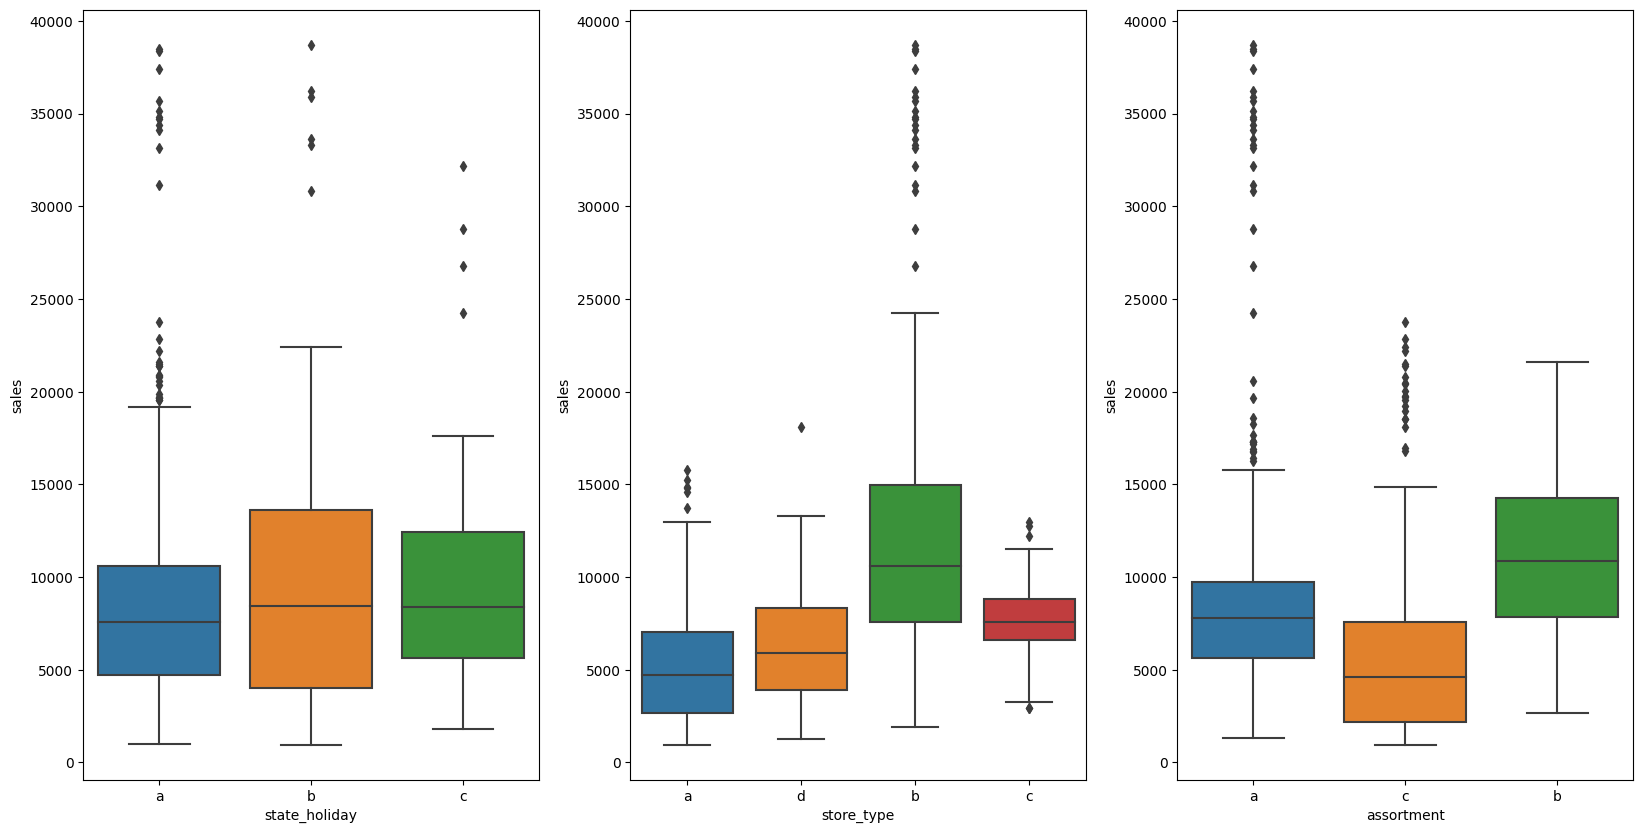

In [21]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );

# 2.0 FEATURE ENGINEERING

Nessa etapa vamos levantar algumas hipoteses a partir de uma mapa metal de hipoteses e criar features a partir das variaveis já existentes.

In [22]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

Para dar inicio ao processo de feature engineering foi criado um mapa mental de hipoteses. Baseando no problema de negócio foi criado diferentes hipoteses separadas por Lojas, Clientes, Produtos, Localização e Temporal.

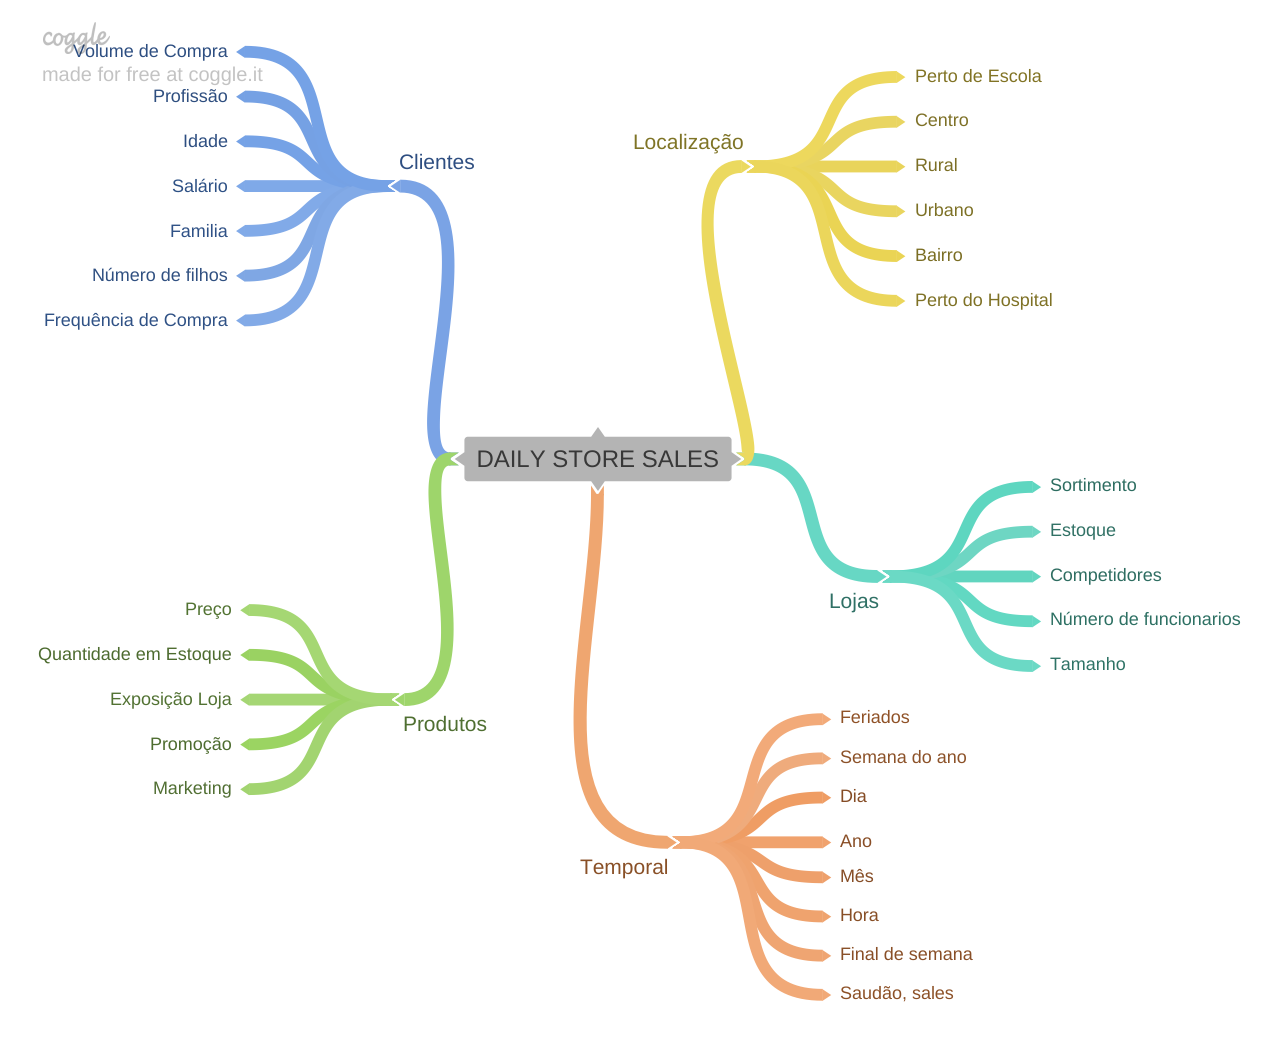

In [23]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação das Hipoteses

### 2.2.1. Hipoteses Loja

1. Lojas com número maior quadro de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

##  2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

Agora começa o processo de extração de novas variavéis a partir das disponiveis no dataframe. As variaveis derivadas abaixo são, respectivamente:
- Ano
- Mês
- Dia
- Semana do ano
- Ano-Semana
- Tempo de competição
- Tempo de competição por mês
- Tempo de promoção
- Tempo de promoção por semana
- Alteração nos valores de assortment/state_holiday para seus devidos significados

In [24]:
# Criando variaveis

# year
df2['year'] = df2['date'].dt.year


# month
df2['month'] = df2['date'].dt.month


# day
df2['day'] = df2['date'].dt.day


# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# competition since
df2['competition_since'] = df2.apply(lambda x : datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )


# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'

# 3.0 VARIABLES FILTERING

Nessa etapa vamos filtrar os dados baseado nas restrições do negócio.

In [ ]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

Linhas onde a loja estava fechada ou com vendas iguais a zero não serão úteis para a modelagem. 

In [ ]:
# filtrando somente as lojas abertas 
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

Agora também selecionamos as colunas que não agregam informação para o modelo.

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 EXPLORATORY DATA ANALYSIS (EDA)

Nessa etapa o objetivo é :
* Entender o negocio e gerar insights.
* Encontrar variaveis relevantes para o aprendizado do modelo.

 (Para isso vamos as hipoteses já criadas)

In [ ]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

No primeiro gráfico abaixo temos a distribuição da varavel resposta "Sales", vemos que sua distribuição não é exatamente uma normal pois apresenta uma skewness positiva, como indicado pela tabela obtida na seção 1.6. Em geral os algoritmos de Machine Learning apresentam um melhor resultado com distribuição normal, podemos então transformar a variavel resposta aplicando uma função ln(x) (será feito mais a frente), obtendo assim uma distribuição mais fiel a uma normal, como mostrado na segunda figura.

In [ ]:
# Distribuição da variavel resposta "sales"
fig = plt.subplots(1,2,figsize=(21,7))

plt.subplot(1,2,1)
sns.histplot(df4['sales'], kde=True, stat="density"); plt.title('Distribuição da variavel sales (sem transformações)');
plt.subplot(1,2,2)
sns.histplot(np.log1p(df4['sales']), kde=True, stat="density"); plt.title('Distribuição da variavel sales com transformação ln(x+1)');


### 4.1.2. Numerical Variable

Podemos notar nos histogramas abaixo que não temos váriavéis númericas que apresentam um distribuição caracteristica, exceto pela váriavel sales, essa porém é a nossa variavél resposta. Isso implica na impossibilidade de aplicar métodos de normalização posteriormente, nos restando utilizar métodos de reescala.

In [ ]:
num_attributes.hist( bins=40,  figsize=(13,10));

### 4.1.3 Categorical Variables

In [ ]:
df4['state_holiday'].drop_duplicates()

In [ ]:
plt.figure(figsize=(15,10))


# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( x = df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot( x = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( x = df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )



# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )



# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x = df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2. Analise Bivariada

Aqui foi verificado se as hipoteses criadas anteriormente são verdadeiras ou falsas.

### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

In [ ]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list (np.arange(0, 20000, 1000))


fig = plt.subplots(figsize=(21,14));
plt.subplot(2,2,1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1);
plt.grid(True)
plt.title('(a) distância até o competidor mais próximo  X vendas');

plt.subplot(2,2,2);
sns.heatmap(aux1.corr(method='pearson'), annot=True);
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)  # o cut coloca em qual grupo o valor pertence
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.title('(b) Correlação entre as variáveis');


plt.subplot(2,2,(3,4));
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=-45);
plt.title('(c) Vendas por faixa de distância');




### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

In [ ]:
plt.subplots(2,2,figsize=(21,14))

aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[aux1['competition_time_month']<120]
aux2 = aux2[aux2['competition_time_month'] != 0]


plt.subplot(2,2,1)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(2,2,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,(3,4))
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=-45);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

In [ ]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()


#grid = GridSpec( 2, 3 )

fig = plt.figure(figsize=(16, 8))
grid = fig.add_gridspec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido

sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. <s/>


### H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

In [ ]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

fig = plt.figure(figsize = (16, 6))
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H9. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

In [ ]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig = plt.figure(figsize=(16, 6))

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

In [ ]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig = plt.figure(figsize=(16, 6))

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

In [ ]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()


fig = plt.figure(figsize = (16, 6)) 

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

In [ ]:
df4.columns

In [ ]:
aux['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')

### H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

In [ ]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

fig=plt.subplots(1,3,figsize=(21,5))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data = aux1);
plt.title('(a) Vendas por dia na semana');

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data = aux1);
plt.title('(b) Ajuste linear entre as variáveis');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);
plt.title('(c) Correlação entre as variáveis');

### H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, exceto nos meses de Julho e
Agosto.

In [ ]:
fig = plt.figure(figsize = (14, 8)) 

aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );


aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

4.2.1. Resumo das Hipoteses

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],

['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

In [ ]:
correlation = num_attributes.corr( method='pearson' )

fig = plt.figure(figsize = (14, 6)) 
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

Para ver a correlação entre as variaveis categoricas vamos usar o [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

fig = plt.figure(figsize = (14, 6)) 
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION


Nessa etapa preparamos os dados. Para isso fazemos algumas transformações, como transformar as variaveis categóricas em númericas, transformar as variaveis númericas de tempo em variaveis ciclica ...

In [ ]:
df5 = df4.copy()

## 5.1. Normalizacao

##### Nenhuma variavel com distribuição normal

A normalização funciona bem variaveis que possuem distribuição normal. Como visto na análise univariavel nenhuma variavel possue esse tipo de distribuição, portanto não vamos usar Normalização.


## 5.2. Rescaling

Como não temos nenhuma variavel categórica, o método de reescaling foi aplicado. MinMaxScaler foi utilizado para colunas que não apresentam Outliers, enquanto que o RobustScaler foi aplicado quando existe outliers.


In [ ]:
rs = RobustScaler()   # Usar quando os outliers são bem fortes
mms = MinMaxScaler()  # Usar quando os outliers não são tão relevantes

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open(os.path.join(PARA_DIR,'competition_distance_scaler.pkl'), 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )
pickle.dump(rs, open(os.path.join(PARA_DIR,'competition_time_month_scaler.pkl'), 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open(os.path.join(PARA_DIR,'promo_time_week_scaler.pkl'), 'wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open(os.path.join(PARA_DIR,'year_scaler.pkl'), 'wb'))


In [ ]:
df5.head(4)

## 5.3 Transformação

### 5.3.1. Encoding

Nas variaveis categoricas foi aplicado técnicas de transformação (onehotencoding, label encoding e ordinal encoding).

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open(os.path.join(PARA_DIR,'store_type_scaler.pkl'), 'wb'))


# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [ ]:
df5.head(4)

### 5.3.2. Response Variable Transformation

A ideia é trazer a distribuição da variavel resposta o mais próximo de uma distribuição normal, para isso vamos aplicar a transformação logaritma.


In [ ]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

Para variaveis de natureza ciclicas (ano, meses, semanas e dias) foi utilizado uma técnica de reescreve-las em seno e cosseno.

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 FEATURE SELECTION

Nessa seção vamos selecionar as varivaveis de interesse para o modelo. Algumas variaveis que foram utilizadas para definir outras (Variaveis Colineares) serão automaticamente descartadas para evitar dependencia linear no modelo. As demais serão escolhidas pelo método do algoritmo Boruta.

In [ ]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

Primeiro deletamos as variaveis que não são importantes para o modelo e em seguida separamos os dados em treino e teste para utilizar no algoritmo Boruta. Como o objetivo da previsão de vendas é de 6 semanas separamos o conjunto de treino sem as últimas seis semanas.


In [ ]:
# primeiro deletamos as variaveis que delas originaram outras variaveis 
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [ ]:
# Vendo qual é a data das 6 últimas semanas (Pegamos a data final do dataframe e subtraimos 6 semanas)
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

In [ ]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

## 6.2. Boruta as Feature Selector

A função boruta julga quais variáveis são relevantes para o modelo, de maneira simplificada, ela faz isso verificando como a performance do modelo se comporta ao adicionar uma nova feature.

Vamos deixar em comentario, pois é um pouco demorado. Ao final vamos deixar os resultados.

In [ ]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()     # ravel() para colocar dentro de um vetor
#
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
#
## define Boruta  
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

### 6.2.1. Best Features from Boruta

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

Aqui só coloco o resultado, já que o boruta demora muito para rodar, cerca de 4 hrs.

In [ ]:
cols_selected_boruta = [

'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',            # adicionado 
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',     # adicionado
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [ ]:
cols_selected_boruta_full

# 7.0 MACHINE LEARNING MODELLING

Com os dados tratados e com as features selecionadas podemos iniciar o processo de ML. Vamos implementar 5 algoritmos de machine learning. Utilizamos a técnica de **Cross Validation** (é um método de reamostragem que usa diferentes partes dos dados para testar e treinar um modelo em diferentes iterações) para comparar os modelos com sua performace real, e com isso escolhemos um dos modelos para seguirmos para próxima etapa.

In [ ]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

Começamos com o modelo de média, é um dos modelos mais simples, a predição é baseada apenas na média de vendas das loja. Embora simples ele é útil para podermos comparar a performance dos modelos a serem testados em seguida.

obs: Lembrando que as vendas foram treinadas usando o log de cada valor da venda, agora para analisar a performace do modelo precisamos voltar para os valores originais, para isso basta aplicarmos a exponencial. Para isso vamos usar o método np.expm1().

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )   
baseline_result

## 7.2. Linear Regression Model

Agora utilizamos o modelo de regressão linear. Vemos nos resultados abaixo que temos uma performance pior que o modelo de média, isso indica que nosso conjunto de dados não segue uma distribuição linear e portanto esses tipos de modelo não são os melhores para tentar descreve-los.

In [ ]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

### 7.2.1. Linear Regression Model - Cross Validation

O método de cross-validation nos mostra que o real desempenho da regressão linear é ainda pior do que parecia, pois temos um maior RMSE.

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

## 7.3. Linear Regression Regularized Model - Lasso

Agora aplicamos outro método linear, LASSO, e obtemos mais uma evidência de que métodos lineares não descrevem bem o conjunto de dados que está sendo trabalhado.

In [ ]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )    # alpha é o fator multiplicativo de cada um dos pesos, para que eles fiquem dentro de um range.
# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

### 7.3.1. Linear Regression Regularized Model (Lasso) - Cross Validation

O método de cross-validation nos mostra que o real desempenho do modelo é ainda pior do que parecia, pois temos um maior RMSE.

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

## 7.4 Random Forest Regressor

Partimos agora para os métodos não lineares, começando com a random forest regressor. Podemos notar uma performance muito melhor em comparação aos métodos não lineares e a média.

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )  

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

Ao aplicar o cross-validation no random forest vemos que seu desempenho diminui, mas se mantém alto, se mostrando uma boa opção para ser utilizado.

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

## 7.5 XGBoost Regressor

O XGBoost também apresenta um bom desempenho.

In [ ]:
# model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
#                              n_estimators=100, 
#                              eta=0.01,
#                              max_depth=10,
#                              subsample=0.7,
#                              colsample_bytree=0.5 ).fit( x_train, y_train )  

model_xgb = xgb.XGBRegressor(objective='reg:squarederror').fit(x_train, y_train)


# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation

O desempenho do XGBoost é confirmado ao aplicar o cross validation, embora não seja tão bom quanto ao random forest regressor ele entrega desempenho próximo e com menos tempo de processamento.

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

## 7.6 Compare Model's Performance

A seguir temos as classificações dos algoritmos baseada no RMSE. Vemos que a random forest regressor é a que apresenta um RMSE mais baixo, seguida pelo xgboost, a principio o ideal seria continuar com a 'Random Forest Regressor', porém como já comentado, o 'XGBoost' apresenta um desempenho semelhante com um tempo de processamento bem menor, portanto seguiremos com ele.

### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, 
                               xgb_result] )
modelling_result.sort_values( 'RMSE' )

### 7.6.2. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values('RMSE CV')

Aqui o mais correto seria escolher o Random Forest Regressor, já que comparado com os outros modelos possui o menor RMSE. Pórem como forma de aprendizado pessoal vamos seguir com o XGBoost Regressor.

# 8.0 Hyperparameter Fine Tunning

Na etapa 7.0 decidimos seguir com o XGBoost Regressor e agora nessa etapa vamos escolher os melhores parametros para o aprendizado do modelo. A técnia utilizada aqui foi a Random Search, onde manualmente alteramos os parametros do modelo escolhido e consideramos aquele que apresenta a melhor performance. Antes de calcular a eficiência dos modelos as váriavéis resposta foram transformadas de volta através da função exponêncial.



## 8.1 Random Search

Valores aleatórios para os parametros do XGBoost.

In [ ]:
param = {'n_estimators': [500,1000,2000,3000,3500],
        'eta': [0.1,0.01,0.03],
        'max_depth': [3,5,9, 12],
        'subsample': [0.1,0.5,1],
        'colssample_bytree': [0.3,0.7,1],
        'min_child_weight': [1,3,8,15]}

max_eval = 10

Teste aleatório desses valores. Aleatoriamente fizemos 10 tentavivas e escolhemos a melhor.

 Deixamos o código em comentario por ser um processo muito demorado.


In [ ]:
#final_result = pd.DataFrame()

#for i in range (max_eval):
    #choose values for parameters remdomly
#    hp = {k: random.sample(v,1)[0] for k,v in param.items()}
#    print(hp)
    
    #model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                    n_estimators=hp['n_estimators'],
#                                    eta=hp['eta'],
#                                    max_depth=hp['max_depth'],
#                                    subsample=hp['subsample'],
#                                    colsample_bytree=hp['colssample_bytree'],
#                                    min_child_weight=hp['min_child_weight'])

    # performance
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#    final_result = pd.concat([final_result, result])
    
#final_result

## 8.2 Final Model

Após realizar vários ajustes de maneira aleatória pegamos os parametros que apresentaram melhor performance e treinamos o modelo final.

In [ ]:
param_tuned = {'n_estimators': 500,
               'eta': 0.1,
               'max_depth': 12,
               'subsample': 1,
               'colssample_bytree': 1,
               'min_child_weight': 1}

In [ ]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colssample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
# prediciton
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
    
# performance
xgb_result_tuned = ml_error(' XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned




In [ ]:
mpe = mean_percentage_error(np.expm1(y_test),np.expm1(yhat_xgb_tuned))

mpe

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( 'model/model_rossmann.pkl', 'wb' ) )

# 9.0 Tradução e interpretação do erro

O objetivo nessa etapa é traduzir a performace do modelo em performace do negocio. (Como o resultado encontrado do modelo vai empactar no negócio?)

In [ ]:
# def open_trained_model():
#     return open('Model/store_sales_prediction_model.pkl', 'rb')

# with open_trained_model() as f:
#     model_xgb_tuned = pickle.load(f) 

# yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [ ]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [ ]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE AND MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [ ]:
df92.head(5)

In [ ]:
# Vendo que existe lojas dificeis de usar um modelo (tem o MAPE muito alto)
df92.sort_values('MAPE', ascending=False).head()

In [ ]:
# plot do MAPE das lojas
sns.scatterplot(x='store',y='MAPE', data=df92)

## 9.2 Total Performance

In [ ]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={0:'Values', 'index':'Scenario'})
df93['Values'] = df93['Values'].map('R$ {:.2f}'. format)
df93


## 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle('Desempenho do modelo', fontsize=20)

# Comparando as vendas com as predições
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales', data=df9, label='Sales')
sns.lineplot(x='date',y='predictions', data=df9, label='Predictions'); plt.title('Vendas reais e valores previstos pelo modelo')

# Analisando o comportamento do erro do modelo (O modelo perfeito seria uma linha constante em 1)
plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9); plt.title('Taxa de erro (Previsão / Real)')
plt.axhline(1, linestyle='--')

# Distribuição do erro
plt.subplot(2,2,3)
sns.distplot(df9['error']); plt.title('Distribuição dos erros absolutos')

# Grafico de residuo (as predições com relação ao erro)
plt.subplot(2,2,4)
sns.scatterplot(x = df9['predictions'], y = df9['error']); plt.title('Valor dos erros em relação aos valores previstos')


plt.savefig('model_performance.png')
plt.show()


# 10.0 DEPLOY MODEL TO PRODUTION

Nessa etapa colocamos o modelo em produção para as pessoas usarem o resultado.

Para isso seguimos as seguintes etapas:

1. Criar uma classe com as limpezas, transformações e encoding, chamada de Rossmann.py

2. Criar a API usando o framework Flask, chamada Handler.py

3. Criar um Script para testar a API

## 10.1 Loading test dataset

In [ ]:
df10 = pd.read_csv( 'dados/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
df_test.head()

## 10.2 Establishing connection (local server)

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )


# API Call
url = 'http://192.168.100.120:5000/rossmann/predict'

header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

## 10.3 Establishing connection (online server)

In [ ]:
# url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
# header = {'Content-type': 'application/json' }
# data = data
# r = requests.post( url, data=data, headers=header )
# print( 'Status Code {}'.format( r.status_code ) )

## 11.4 Previsão

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

d1.head()

In [ ]:
d2 =d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('A loja número {} vai vender ${:,.2f} nas proximas 6 semanas.'. format(d2.loc[i,'store'], d2.loc[i,'prediction']))